<a href="https://colab.research.google.com/github/matteogorni2/Crowd-counting-computer-vision-project/blob/main/VCS_Crowd_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importazione pacchetti e creazione DataLoader

In [1]:
import os

import numpy as np
import pandas as pd
import scipy as sc
from scipy.io import loadmat
import scipy.stats as stats
from scipy import ndimage
from scipy.ndimage import gaussian_filter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, VGG19

from keras.applications.vgg16 import VGG16
from keras.initializers import RandomNormal
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras import backend as K


from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau

import cv2
import itertools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications import Xception

In [2]:
%%capture
!unzip mall_dataset.zip

In [3]:
# Load annotations and create DataFrame
gt = loadmat('mall_dataset/mall_gt.mat')
df = pd.DataFrame({
    'count': gt['count'].flatten(),
    'annotations': [frame_data[0][0][0] for frame_data in gt['frame'][0]]})
df = df.reset_index()
df = df.rename({'index': 'frame_id'}, axis=1)
df.frame_id = df.index + 1
df['image_name'] = df['frame_id'].apply(lambda x: f'seq_{x:06d}.jpg')

df

,frame_id,count,annotations,image_name
0,1,29,"[[126.77986348122866, 60.70477815699661], [116...",seq_000001.jpg
1,2,30,"[[57.155290102389046, 199.13481228668945], [87...",seq_000002.jpg
2,3,35,"[[118.73899371069183, 43.77044025157227], [134...",seq_000003.jpg
3,4,31,"[[140.87735849056602, 44.77672955974833], [151...",seq_000004.jpg
4,5,26,"[[123.77044025157232, 51.82075471698107], [145...",seq_000005.jpg
...,...,...,...,...
1995,1996,27,"[[454.8737166324436, 45.34599589322369], [462....",seq_001996.jpg
1996,1997,27,"[[367.48151950718693, 59.14476386036961], [395...",seq_001997.jpg
1997,1998,25,"[[22.512320328542103, 245.09958932238186], [73...",seq_001998.jpg
1998,1999,26,"[[22.512320328542103, 290.43839835728943], [99...",seq_001999.jpg


In [4]:
# Creazione di image_sequences con il percorso completo
img_paths = np.array([f"mall_dataset/frames/{img}" for img in df['image_name']])
print(f'Number of images: {len(img_paths)}')

# Annotazioni
mall_dataset_folder = 'mall_dataset/'
mall_gt =loadmat(os.path.join(mall_dataset_folder, 'mall_gt.mat'))
mall_head_positions_gt = mall_gt['frame'][0]
print(f'Number of annotations: {len(mall_head_positions_gt)}')

Number of images: 2000
Number of annotations: 2000


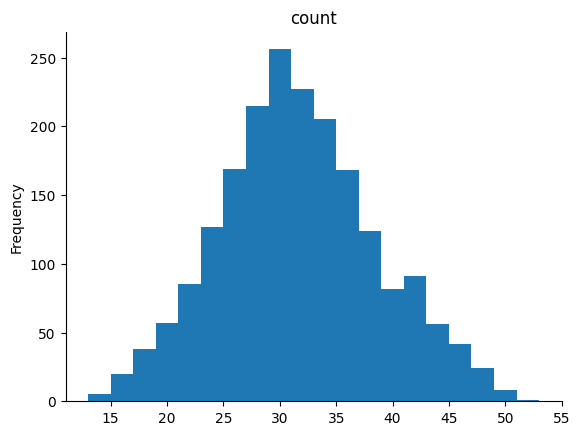

In [5]:
# counts
from matplotlib import pyplot as plt
df['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
def plot_training_history_simple(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

In [7]:
#Computes the Euclidean loss as described in the paper
def euclidean_loss(y_true, y_pred):
    squared_diff = K.square(y_pred - y_true)
    loss = K.mean(squared_diff) / 2
    return loss


In [8]:
## FUNZIONE DI PREDIZIONE
# funzione valida per tutti i modelli

def full_eval(x, model, smooth=False):
    batch_size = x.shape[0]  # Ora gestiamo più immagini contemporaneamente
    counts_batch = np.zeros(batch_size)  # Array per salvare i count predetti per ogni immagine

    for b in range(batch_size):  # Iteriamo sulle immagini nel batch
        predicted_count = 0  # Variabile per il count predetto per una singola immagine

        # Predici il count per l'immagine b
        predicted_count = model.predict(x[b:b+1])[0]  # CSRNet restituisce il count per l'immagine

        if smooth:
            # Se richiesto, applica il filtro gaussiano alla mappa di densità
            # (Questo passo potrebbe non essere necessario se il predict restituisce già il count finale)
            density_map = model.predict(x[b:b+1])[0]
            density_map = gaussian_filter(density_map, 2, mode='constant')
            predicted_count = np.sum(density_map)  # Calcola il count anche dopo smoothing

        counts_batch[b] = predicted_count  # Salviamo il count predetto per l'immagine corrente

    return counts_batch  # Restituiamo il batch di count predetti

In [9]:
# Create a function to generate resized images
def create_images_mall(imgs_paths, save_path):
    for i, img_path in enumerate(imgs_paths):
        img = plt.imread(img_path)
        file_path = os.path.join(save_path, f'seq_{i+1}.jpg')
        cv2.imwrite(file_path, img)

In [10]:
save_path = 'mall_dataset/images/'
os.makedirs(save_path, exist_ok=True)

create_images_mall(img_paths, save_path)

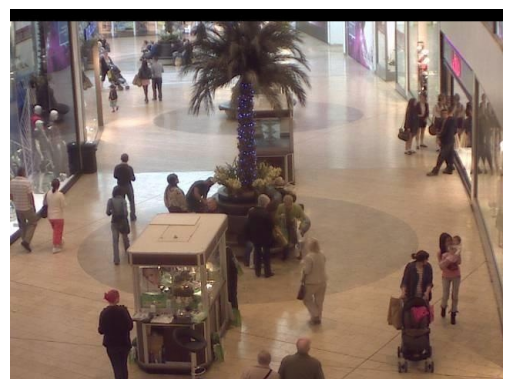

In [11]:
path_images = 'mall_dataset/images/'
image_files_names = sorted([f for f in os.listdir(path_images) if f.endswith('.jpg')])
images_files = [cv2.imread(os.path.join(path_images, f)) for f in image_files_names]

plt.imshow(images_files[0])
plt.axis("off")
plt.show()


##Data augmentation

In [12]:
def create_flip_images(images_files, new_image_count, df):
    save_path_images = 'mall_dataset/frames/'
    new_rows = []
    start_frame_id = df["frame_id"].max() + 1  # Start frame ID after the last existing one

    for i in range(new_image_count):
        image = images_files[i]
        head_count = df.iloc[i]["count"]
        annotations = np.array(df.iloc[i]["annotations"])  # Convert annotations to NumPy array

        # Horizontally flip the image
        flipped_image = cv2.flip(image, 1)
        new_image_name = f'seq_00{2000+i+1}.jpg'
        file_path_img = os.path.join(save_path_images, new_image_name)

        cv2.imwrite(file_path_img, flipped_image)

        # Adjust annotations for the flipped image
        img_width = image.shape[1]  # Get image width
        flipped_annotations = annotations.copy()
        flipped_annotations[:, 0] = img_width - annotations[:, 0]  # Mirror x-coordinates

        # Append new image details to the dataframe
        new_rows.append({
            "frame_id": start_frame_id + i,
            "count": head_count,
            "annotations": flipped_annotations.tolist(),
            "image_name": new_image_name
        })

        images_files.append(flipped_image)

    # Add new rows to the dataframe
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

    print(f"Added {new_image_count} flipped images and updated the dataframe.")

    return df  # Return the updated dataframe


In [13]:
df=create_flip_images(images_files,2000,df)

Added 2000 flipped images and updated the dataframe.


## Data generator

In [14]:
class DataGenerator_count(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True, target_size=(224, 224), model_type="vgg16"):
        self.df = dataframe.sample(frac=1).reset_index(drop=True) if shuffle else dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.frames_dir = 'mall_dataset/frames'
        self.target_size = target_size
        self.model_type = model_type


    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        # Estrae il batch di immagini
        batch_df = self.df[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []

        for _, row in batch_df.iterrows():
            image_path = os.path.join(self.frames_dir, row.image_name)
            image = cv2.imread(image_path)
            if image is not None:
                image = self.preprocess_image(self.resize_image(image))  # Applica resize e normalizzazione
                X.append(image)
                y.append(row['count'])  # Usa il numero di persone come target
            else:
                print(f"Warning: Could not load image at {image_path}")

        X = np.array(X)
        y = np.array(y)
        return np.array(X), np.array(y).astype(float) # Converti y in formato float per la regressione


    def resize_image(self, image):
        # Ridimensiona l'immagine alle dimensioni target (e.g., 224x224)
        image_resized = cv2.resize(image, self.target_size)
        return image_resized

    def preprocess_image(self, image):
        image = image.astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.model_type == "resnet":
            return resnet_preprocess(image)
        elif self.model_type == "vgg16":
            return vgg_preprocess(image)
        elif self.model_type == "vgg19":
            return vgg19_preprocess(image)
        elif self.model_type == "xception":
            return xception_preprocess(image)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [15]:
# Split dataset
train_val_df_count, test_df_count = train_test_split(df, test_size=0.2, random_state=42)
train_df_count, valid_df_count = train_test_split(train_val_df_count, test_size=0.2, random_state=42)

In [16]:
# Esempio
train_gen = DataGenerator_count(train_df_count)
valid_gen = DataGenerator_count(valid_df_count)
test_gen = DataGenerator_count(test_df_count)

# Verifica forma dei dati
x_batch_count, y_batch_count = next(iter(train_gen))
print("Input batch shape:", x_batch_count.shape)  # Output: (32, 480, 640, 3)
print("Target batch shape:", y_batch_count.shape)  # Output: (32,)

Input batch shape: (32, 224, 224, 3)
Target batch shape: (32,)


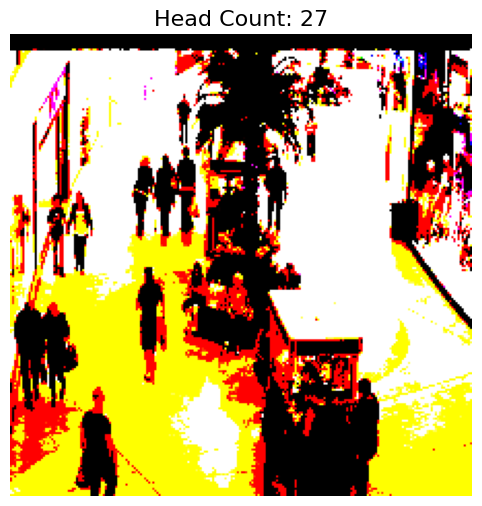

In [19]:
# Fetch the first batch
X_batch, y_batch = train_gen[1]

# Select the first example of the batch
image = X_batch[0]
count = y_batch[0]

# Plotting
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f'Head Count: {int(count)}', fontsize=16)
plt.axis('off')
plt.show()

# RESNET50

In [20]:
# Generator for resnet
train_gen_resnet = DataGenerator_count(train_df_count, batch_size=32, model_type="resnet")
valid_gen_resnet = DataGenerator_count(valid_df_count, batch_size=32, shuffle=False, model_type="resnet")
test_gen_resnet = DataGenerator_count(test_df_count, batch_size=32, shuffle=False, model_type="resnet")

In [21]:
base_model1 = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(224, 224, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [22]:
base_model1.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Here we change the top (the last parts) of the network.
x = base_model1.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [ ]:
model1 = Model(inputs=base_model1.input, outputs=predictions)

In [ ]:
k = -7
for layer in model1.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model1.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense_12
dense_13


In [ ]:
model1.summary()

In [ ]:
# Report multiple hyperparameters using a dictionary:
hyper_params = {
  "adam": 0.001, # 0.0001 e 0.001
  "epochs": 50, # 30 e 50
  "metric": ['mae'],  #['mae'] e ['mse']
  "loss": 'mse', #mse e euclidean
  "early_stopping_patience": 3 # 2 e 5
}

adam = Adam(learning_rate=hyper_params['adam'])

es = EarlyStopping(monitor='val_mae', #da cambiare in base alla loss (val_mae per MSE, val_mse per euclidean)
                   mode='min',
                   patience=hyper_params['early_stopping_patience'])

In [ ]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mae',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [ ]:
model1.compile(optimizer=adam, loss=hyper_params['loss'], metrics=hyper_params['metric'])

In [ ]:
history1 = model1.fit(train_gen_resnet, epochs=hyper_params["epochs"], validation_data=valid_gen_resnet, callbacks=[learning_rate_reduction, es])

Epoch 1/50


/Users/beatricespagnolo/Documents/VSCode/vcs/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - loss: 240.1543 - mae: 12.1092 - val_loss: 58.5584 - val_mae: 6.5869 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - loss: 20.7573 - mae: 3.6551 - val_loss: 25.0206 - val_mae: 4.1599 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - loss: 11.6944 - mae: 2.6997 - val_loss: 10.3523 - val_mae: 2.4743 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - loss: 7.9673 - mae: 2.2625 - val_loss: 16.7952 - val_mae: 3.2162 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - loss: 7.4299 - mae: 2.1768 - val_loss: 16.2783 - val_mae: 3.1987 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 6.4174 - mae: 2.0349
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - loss: 6.4011 - mae: 2.0318 - val_loss: 13.8601 - val_mae: 2.8927 - learning_rate: 0.

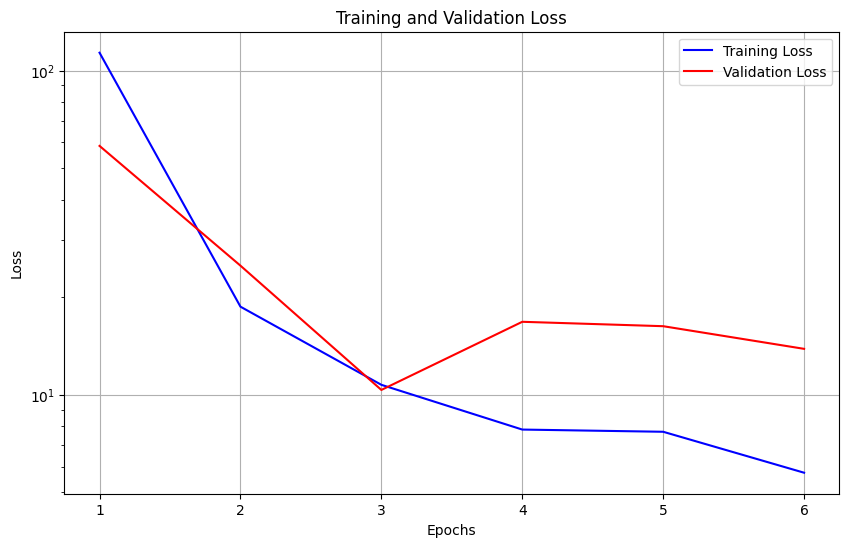

In [ ]:
plot_training_history_simple(history1)

## Prediction

In [ ]:
# Itera sui batch del generatore di test
predicted_counts = []
true_counts = []

for i in range(test_gen_resnet.__len__()):
    batch_images, batch_labels = test_gen_resnet[i]
    predicted_counts.append(full_eval(batch_images, model1, smooth=False))
    true_counts.append(batch_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/var/folders/0b/vd_cmbld7rv9370g89w16hf80000gn/T/ipykernel_44888/1790504739.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts_batch[b] = predicted_count  # Salviamo il count predetto per l'immagine corrente


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [ ]:
# Concatena i risultati per avere un array continuo di valori
predicted_counts = np.concatenate(predicted_counts)
true_counts = np.concatenate(true_counts)

# Calcola le metriche
mae = mean_absolute_error(true_counts, predicted_counts)  # Mean Absolute Error
mse = mean_squared_error(true_counts, predicted_counts)  # Mean Squared Error
pearson_corr, _ = pearsonr(true_counts, predicted_counts)  # Pearson correlation
rmse_value = np.sqrt(mean_squared_error(true_counts, predicted_counts))

# Stampa i risultati
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"Pearson correlation: {pearson_corr}")
print(f"RMSE: {rmse_value}")

MAE: 2.9200906991958617
MSE: 13.419189914880253
Pearson correlation: 0.9087347153965974
RMSE: 3.66322124842061


# VGG16

In [ ]:
# Generator for vgg16
train_gen_vgg16 = DataGenerator_count(train_df_count, batch_size=32, model_type="vgg16")
valid_gen_vgg16 = DataGenerator_count(valid_df_count, batch_size=32, shuffle=False, model_type="vgg16")
test_gen_vgg16 = DataGenerator_count(test_df_count, batch_size=32, shuffle=False, model_type="vgg16")

In [ ]:
base_model_VGG16 = vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)

2025-02-11 10:59:12.926981: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-02-11 10:59:12.927002: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-11 10:59:12.927006: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-11 10:59:12.927043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-11 10:59:12.927054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Here we change the top of the network.
x = base_model_VGG16.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [ ]:
model2 = Model(inputs=base_model_VGG16.input, outputs=predictions)

In [ ]:
k = -7
for layer in model2.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model2.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense
dense_1


In [ ]:
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
input_shape = (224, 224, 3)
hyper_params = {
    "loss": euclidean_loss,  # Euclidean o MSE
    "metric": ['mse'], # "mae" with MSE loss / "mse" with euclidean loss
    "adam": 0.001,
    "epochs": 50,
    "early_stopping_patience": 5 # 10, 30
}

adam = Adam(learning_rate=hyper_params['adam'])

es = EarlyStopping(monitor='val_mse', #da cambiare in base alla loss (val_mae per MSE, val_mse per euclidean)
                   mode='min',
                   patience=hyper_params['early_stopping_patience'])

In [ ]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mse',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [ ]:
model2.compile(optimizer=adam, loss=hyper_params['loss'], metrics=hyper_params['metric'])

In [ ]:
history = model2.fit(
                train_gen_vgg16,
                epochs=hyper_params["epochs"],
                validation_data=valid_gen_vgg16,
                callbacks=[learning_rate_reduction, es])

/Users/beatricespagnolo/Documents/VSCode/vcs/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/50


2025-02-11 10:59:52.826860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 525ms/step - loss: 26652.6406 - mse: 53305.2812 - val_loss: 149.6980 - val_mse: 299.3960 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 515ms/step - loss: 66.8131 - mse: 133.6262 - val_loss: 25.7101 - val_mse: 51.4202 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - loss: 28.7807 - mse: 57.5614 - val_loss: 25.9257 - val_mse: 51.8514 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - loss: 25.6674 - mse: 51.3347 - val_loss: 24.7289 - val_mse: 49.4577 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 514ms/step - loss: 26.2789 - mse: 52.5579 - val_loss: 22.4246 - val_mse: 44.8493 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 521ms/step - loss: 24.5611 - mse: 49.1223 - val_loss: 22.3320 - val_mse: 44.6640 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 529ms/step - loss: 22.9481 - mse: 45.8962 - val_loss: 18.4125 - val_mse: 36.82

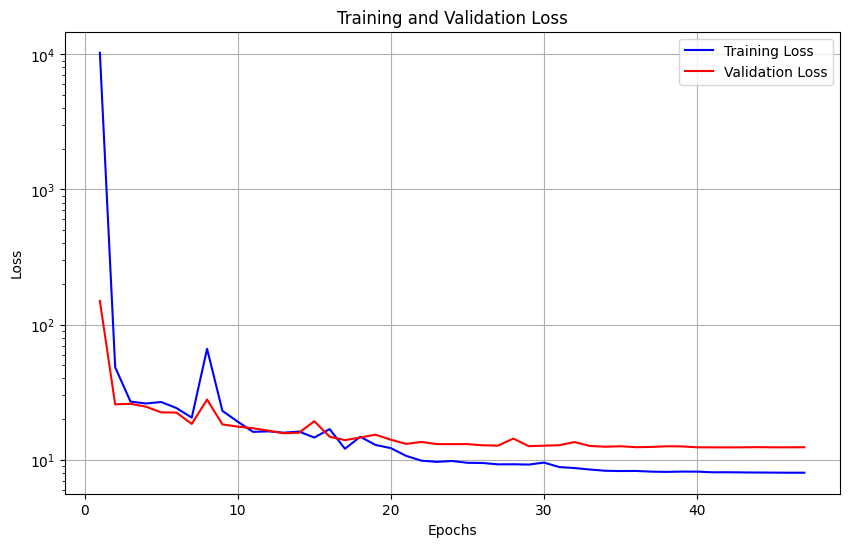

In [ ]:
plot_training_history_simple(history)

## Prediction

In [ ]:
# Itera sui batch del generatore di test
predicted_counts = []
true_counts = []

for i in range(test_gen_vgg16.__len__()):
    batch_images, batch_labels = test_gen_vgg16[i]
    print(f"Batch {i+1}/{len(test_gen_vgg16)}")
    predicted_counts.append(full_eval(batch_images, model2, smooth=False))
    true_counts.append(batch_labels)

Batch 1/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

/var/folders/0b/vd_cmbld7rv9370g89w16hf80000gn/T/ipykernel_54795/968234987.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts_batch[b] = predicted_count  # Salviamo il count predetto per l'immagine corrente


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [ ]:
# Concatena i risultati per avere un array continuo di valori
predicted_counts = np.concatenate(predicted_counts)
true_counts = np.concatenate(true_counts)

# Calcola le metriche
mae = mean_absolute_error(true_counts, predicted_counts)  # Mean Absolute Error
mse = mean_squared_error(true_counts, predicted_counts)  # Mean Squared Error
pearson_corr, _ = pearsonr(true_counts, predicted_counts)  # Pearson correlation
rmse_value = np.sqrt(mean_squared_error(true_counts, predicted_counts))

# Stampa i risultati
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"Pearson correlation: {pearson_corr}")
print(f"RMSE: {rmse_value}")

MAE: 3.86630211353302
MSE: 23.846299221257297
Pearson correlation: 0.687869655265461
RMSE: 4.8832672690789


# VGG19

In [ ]:
# Generator for vgg19
train_gen_vgg19 = DataGenerator_count(train_df_count, batch_size=32, model_type="vgg19")
valid_gen_vgg19 = DataGenerator_count(valid_df_count, batch_size=32, shuffle=False, model_type="vgg19")
test_gen_vgg19 = DataGenerator_count(test_df_count, batch_size=32, shuffle=False, model_type="vgg19")

In [ ]:
base_model_VGG19 = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)

In [ ]:
# Here we change the top (the last parts) of the network.
x = base_model_VGG19.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [ ]:
model3 = Model(inputs=base_model_VGG19.input, outputs=predictions)

In [ ]:
k = -7
for layer in model3.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model3.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d_9
dense_18
dense_19


In [ ]:
model3.summary()

In [ ]:
## Da modificare per test futuri
input_shape = (224, 224, 3)
hyper_params = {
    "loss": 'mse',  # Euclidean o MSE
    "metric": ['mae'], # "mae" with MSE loss / "mse" with euclidean loss
    "adam": 0.0001,
    "epochs": 50,
    "batch_size": 32,
    "early_stopping_patience": 5
}

adam = Adam(learning_rate=hyper_params['adam'])

es = EarlyStopping(monitor='val_mae', #da cambiare in base alla loss (val_mae per MSE, val_mse per euclidean)
                   mode='min',
                   patience=hyper_params['early_stopping_patience'])

# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mae',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [ ]:
# Compile the model
model3.compile(optimizer=adam, loss=hyper_params['loss'], metrics=hyper_params['metric'])

In [ ]:
history3 = model3.fit(
                train_gen_vgg19,
                epochs=hyper_params["epochs"],
                validation_data=valid_gen_vgg19,
                callbacks=[learning_rate_reduction, es]
                )

Epoch 1/50


/Users/beatricespagnolo/Documents/VSCode/vcs/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 641ms/step - loss: 194.0676 - mae: 11.0058 - val_loss: 17.3882 - val_mae: 3.3411 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 633ms/step - loss: 13.1668 - mae: 2.8925 - val_loss: 8.7087 - val_mae: 2.2716 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 659ms/step - loss: 7.2304 - mae: 2.0930 - val_loss: 8.2647 - val_mae: 2.1904 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 661ms/step - loss: 5.3891 - mae: 1.8368 - val_loss: 7.6982 - val_mae: 2.1318 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 688ms/step - loss: 4.8043 - mae: 1.7204 - val_loss: 5.6163 - val_mae: 1.8454 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 821ms/step - loss: 4.3072 - mae: 1.6619 - val_loss: 5.2908 - val_mae: 1.7899 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 834ms/step - loss: 3.2179 - mae: 1.4117 - val_loss: 5.8450 - val_mae: 1.8989 - lea

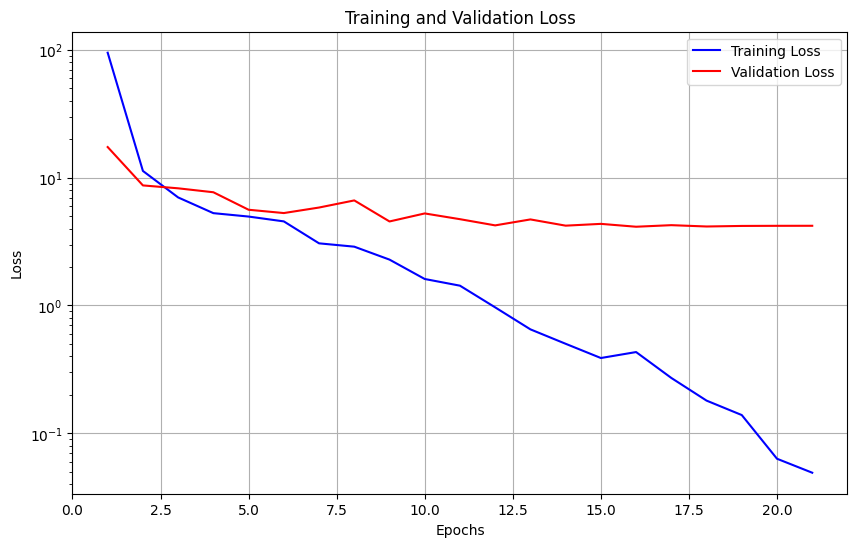

In [ ]:
plot_training_history_simple(history3)

### Prediction

In [ ]:
# Itera sui batch del generatore di test
predicted_counts = []
true_counts = []

for i in range(test_gen_vgg19.__len__()):
    batch_images, batch_labels = test_gen_vgg19[i]
    print(f"Batch {i+1}/{len(test_gen_vgg19)}")
    predicted_counts.append(full_eval(batch_images, model3, smooth=False))
    true_counts.append(batch_labels)

Batch 1/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/var/folders/0b/vd_cmbld7rv9370g89w16hf80000gn/T/ipykernel_55245/968234987.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts_batch[b] = predicted_count  # Salviamo il count predetto per l'immagine corrente


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [ ]:
# Concatena i risultati per avere un array continuo di valori
predicted_counts = np.concatenate(predicted_counts)
true_counts = np.concatenate(true_counts)

# Calcola le metriche
mae = mean_absolute_error(true_counts, predicted_counts)  # Mean Absolute Error
mse = mean_squared_error(true_counts, predicted_counts)  # Mean Squared Error
pearson_corr, _ = pearsonr(true_counts, predicted_counts)  # Pearson correlation
rmse_value = np.sqrt(mean_squared_error(true_counts, predicted_counts))

# Stampa i risultati
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"Pearson correlation: {pearson_corr}")
print(f"RMSE: {rmse_value}")

MAE: 1.789466392993927
MSE: 5.284363000421792
Pearson correlation: 0.9388926242351632
RMSE: 2.298774238680648


# Xception

In [ ]:
# Generator for Xception
train_gen_Xception = DataGenerator_count(train_df_count, batch_size=32, model_type="xception")
valid_gen_Xception = DataGenerator_count(valid_df_count, batch_size=32, shuffle=False, model_type="xception")
test_gen_Xception = DataGenerator_count(test_df_count, batch_size=32, shuffle=False, model_type="xception")

In [ ]:
base_model3 = Xception(
    weights='imagenet',  # Use pre-trained weights
    input_shape=(224, 224, 3),  # Custom input shape (height, width, channels)
    include_top=False,

    pooling='avg',  # Global average pooling to reduce the spatial dimensions to 1x1
)

for layer in base_model3.layers:
    layer.trainable = False

In [ ]:
base_model3.summary()

In [ ]:
x = base_model3.output  #DA CAPIRE POOLING
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

In [ ]:
model3 = Model(inputs=base_model3.input, outputs=predictions)

In [ ]:
model3.summary()

In [ ]:

input_shape = (224, 224, 3)
hyper_params = {
    "loss": euclidean_loss,  # Euclidean o MSE
    "metric": ['mse'], # "mae" with MSE loss / "mse" with euclidean loss
    "adam": 0.0001,
    "epochs": 50,
    "batch_size": 32,
    "early_stopping_patience": 5
}

adam = Adam(learning_rate=hyper_params['adam'])

es = EarlyStopping(monitor='val_mse', #da cambiare in base alla loss (val_mae per MSE, val_mse per euclidean)
                   mode='min',
                   patience=hyper_params['early_stopping_patience'])

# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mse',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [ ]:
# Compile the model
model3.compile(optimizer=adam, loss=hyper_params['loss'], metrics=hyper_params['metric'])

In [ ]:
history3 = model3.fit(
                train_gen_Xception,
                epochs=hyper_params["epochs"],
                validation_data=valid_gen_Xception,
                callbacks=[learning_rate_reduction, es]
                )

Epoch 1/50


/Users/beatricespagnolo/Documents/VSCode/vcs/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 241.2262 - mse: 482.4525 - val_loss: 38.3599 - val_mse: 76.7197 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 427ms/step - loss: 30.6975 - mse: 61.3950 - val_loss: 28.5762 - val_mse: 57.1523 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 423ms/step - loss: 23.7171 - mse: 47.4342 - val_loss: 22.4524 - val_mse: 44.9047 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 448ms/step - loss: 20.8534 - mse: 41.7069 - val_loss: 18.8677 - val_mse: 37.7354 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - loss: 17.1510 - mse: 34.3020 - val_loss: 16.6032 - val_mse: 33.2065 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 452ms/step - loss: 15.9357 - mse: 31.8715 - val_loss: 15.2997 - val_mse: 30.5993 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - loss: 13.4382 - mse: 26.8764 - val_loss: 13.7319

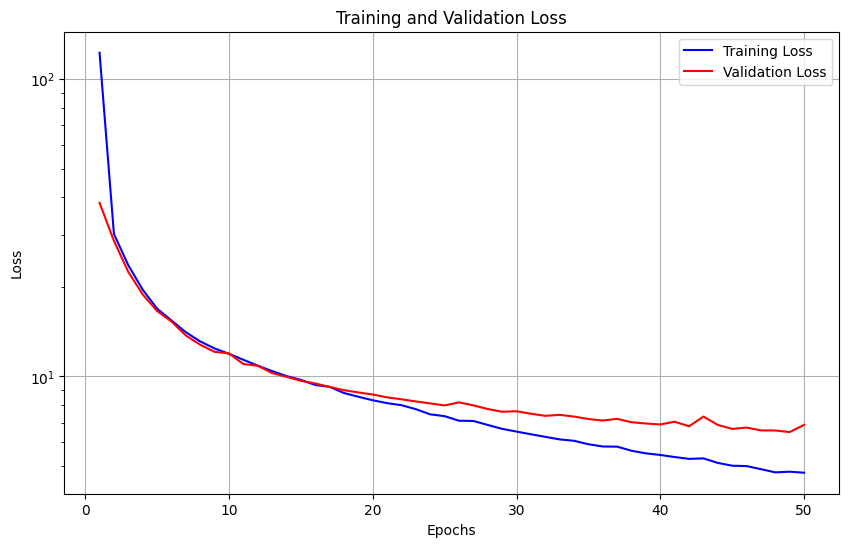

In [ ]:
plot_training_history_simple(history3)

In [ ]:
experiment.log_dataset_hash(train_gen)
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : noble_manatee_9212
COMET INFO:     url                   : https://www.comet.com/beaspagnolo/vcs-heatcount-xception/e5b3fc2cf4e04467aefedceddd8dda2c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_batch_loss [200]         : (2.7182559967041016, 507.441162109375)
COMET INFO:     train_batch_mse [200]          : (5.436511993408203, 1014.88232421875)
COMET INFO:     train_epoch_duration [50]      : (16.857709375000923, 22.80785541700061)
COMET INFO:     train_learning_rate            : 9.999999747378752e-05
COMET INFO:     train_loss [50]                : (4.745484828948975, 122.5870361328125)
COMET INFO:     train_mse [50]              

## Prediction

In [ ]:
# Itera sui batch del generatore di test
predicted_counts = []
true_counts = []

for i in range(test_gen_Xception.__len__()):
    batch_images, batch_labels = test_gen_Xception[i]
    print(f"Batch {i+1}/{len(test_gen_Xception)}")
    predicted_counts.append(full_eval(batch_images, model3, smooth=False))
    true_counts.append(batch_labels)

Batch 1/13
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/var/folders/0b/vd_cmbld7rv9370g89w16hf80000gn/T/ipykernel_55245/968234987.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts_batch[b] = predicted_count  # Salviamo il count predetto per l'immagine corrente


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [ ]:
# Concatena i risultati per avere un array continuo di valori
predicted_counts = np.concatenate(predicted_counts)
true_counts = np.concatenate(true_counts)

# Calcola le metriche
mae = mean_absolute_error(true_counts, predicted_counts)  # Mean Absolute Error
mse = mean_squared_error(true_counts, predicted_counts)  # Mean Squared Error
pearson_corr, _ = pearsonr(true_counts, predicted_counts)  # Pearson correlation
rmse_value = np.sqrt(mean_squared_error(true_counts, predicted_counts))

# Stampa i risultati
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"Pearson correlation: {pearson_corr}")
print(f"RMSE: {rmse_value}")

MAE: 3.1022696328163146
MSE: 15.0650283493579
Pearson correlation: 0.8319839449642276
RMSE: 3.8813693909956446
